# Preprocess and work

- this notebook is used for some pre-processing, like download, statistics, so on and so forth.

In [1]:
# import everything
import gzip
import os
import pickle
import shutil
from collections import Counter

import Bio.PDB as biopdb
import matplotlib.pyplot as plt
import numpy as np
import pymol
import seaborn as sns
import torch
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from pymol import cmd
from sklearn.model_selection import KFold
from tqdm import tqdm

from peptide.mmcif_parsing import parse as mmcif_parse
from scipy.spatial.distance import cdist
import os.path as osp
from torch_geometric.data import Data

/home/xuc0d/anaconda3/envs/Af/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Make data

The part make a data list based on peptide list.

1. assemble the same PDB id

2. Exclude peptide receptor (exists in receptor ids) and contact area < 100, and invalid samples as updated recently 

3. Extract chains for homology clustering

Exclude peptide assemblies and filter with contact area

### 1.1 Extract protein-peptide complex

In [2]:
data_dict = {}
for item in open("raw_data/make_data/peptide_chain.txt").readlines()[1:]:
    try:
        pdb_id, assemble, assemble_chain, peptide_chain, peptide_area, receptor_chain, _, contact_area = item.strip().split('\t')
    except:
        continue  

    if pdb_id not in data_dict:
        data_dict[pdb_id] = {'peptide_chain': [peptide_chain.strip()], 
                             'receptor_chain': [receptor_chain.split(',')],
                             'contact_area': [contact_area.split(',')],
                             'assemble': [assemble.strip()]}
    else:
        data_dict[pdb_id]['peptide_chain'].append(peptide_chain.strip())
        data_dict[pdb_id]['receptor_chain'].append(receptor_chain.split(','))
        data_dict[pdb_id]['contact_area'].append(contact_area.split(','))
        data_dict[pdb_id]['assemble'].append(assemble.strip())
        
valid_data = []
pp_asb = []
for pdb in data_dict:
    name = pdb.split('.')[0].upper()
    peptide_chain = data_dict[pdb]['peptide_chain']
    for pep, rec, area in zip(data_dict[pdb]['peptide_chain'], data_dict[pdb]['receptor_chain'], data_dict[pdb]['contact_area']):
        valid_rec = []
        for ch, ar in zip(rec, area):
            if ch not in peptide_chain and float(ar) > 100:
                valid_rec.append(ch)
        if valid_rec == []:
            pp_asb.append(name + '_' +  pep)
            continue
        valid_rec = '-'.join(valid_rec)
        full_name = f"{name}_{pep}_{valid_rec}"
        valid_data.append(full_name)  
        
valid_data = list(set(valid_data))  # for biological assemblies, this list could have duplicates, check here

In [ ]:
 # missing 3 letter repers.

for data in tqdm(valid_data):
    pdb, _, _ = data.split("_")
    if not os.path.exists(f"./raw_data/3letters/{pdb}.dict"):
        with open(f"./data/peptide_data/raw/{pdb.lower()}.cif", "r") as f:
            cif_data = mmcif_parse(file_id='id', mmcif_string="".join(f.readlines()))
        pickle.dump(cif_data.mmcif_object.seqres_to_structure, open(f"./raw_data/3letters/{pdb}.dict", "wb"))
    if not os.path.exists(f"./raw_data/sequence/{pdb}.dict"):
        with open(f"./data/peptide_data/raw/{pdb.lower()}.cif", "r") as f:
            cif_data = mmcif_parse(file_id='id', mmcif_string="".join(f.readlines()))
        pickle.dump(cif_data.mmcif_object.chain_to_seqres, open(f"./raw_data/sequence/{pdb}.dict", "wb"))


### 1.2 Check duplicates 

using 3 letter sequence, and align with pymol to filter data with small RMSD

Duplicate sequences: same sequence with similar structure

In [3]:
# why? Some sequences are actually the same, check with 3 letter representations.
if os.path.exists("./raw_data/make_data/duplicate_ids_strcut.pkl"):
    duplicate_ids = pickle.load(open("./raw_data/make_data/duplicate_ids_strcut.pkl", "rb"))
else:
    duplicated = {}
    combine_seqs = []

    def get_sequence(tab):
        seq = []
        for k in sorted(tab.keys()):
            seq.append(tab[k].name)
        return '-'.join(seq)

        
    for data in tqdm(valid_data):
        
        pdb, pep, pro = data.split("_")
        
        
        pro_seqs = []
        seq_dict = pickle.load(open(f"./raw_data/3letters/{pdb}.dict", 'rb'))
        dict_ids = list(map(lambda x: x.split("-")[0], list(seq_dict.keys())))

        pro_chains = pro.split("-")
        if pep not in seq_dict:
            print(f"{seq_dict.keys()} {pep} {pdb}")
            continue
        #assert pep in seq_dict, f"{seq_dict.keys()} {pep} {pdb}"
        peptide_seq = get_sequence(seq_dict[pep])
        
        
        for pro in pro_chains:
            pro_seqs.append(get_sequence(seq_dict[pro]))
        pro_seqs = sorted(pro_seqs)
        peptide_seq += '-'
        peptide_seq += '-'.join(pro_seqs)
        duplicated[data] = peptide_seq
       
    def find_duplicate_keys(dic):
        reverse_dic = dict()
        for key, value in dic.items():
            if value in reverse_dic:
                reverse_dic[value].append(key)
            else:
                reverse_dic[value] = [key]
        return [keys for keys in reverse_dic.values() if len(keys) > 1]  # only duplicated ids

    duplicate_ids = find_duplicate_keys(duplicated)
    pickle.dump(duplicate_ids, open("./raw_data/make_data/duplicate_ids_strcut.pkl", "wb"))
print(len(duplicate_ids))

5041


In [4]:

from contextlib import contextmanager
import sys

@contextmanager  # this will suspend pymol output, restart notebook after saving this
def suppress_pymol_output():
    original_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')
    yield
    sys.stdout = original_stdout

def compute_RMSD(p1, p2):
    target1, pep1, pro1 = p1.split("_")
    target2, pep2, pro2 = p2.split("_")
    pymol.cmd.reinitialize() 

    pymol.cmd.load(f"./data/peptide_data/raw/{target1.lower()}.cif", "protein1")
    pymol.cmd.load(f"./data/peptide_data/raw/{target2.lower()}.cif", "protein2")
    
    chains1 = [pep1] + pro1.split("-")
    chains1 = '+'.join(chains1)
    pymol.cmd.select("cp1", f"protein1 and chain {chains1}")
    
    chains2 = [pep2] + pro2.split("-")
    chains2 = '+'.join(chains2)
    pymol.cmd.select("cp2", f"protein2 and chain {chains2}")

    alignment_result = pymol.cmd.align("cp1", "cp2")
    rmsd = alignment_result[0]
    return rmsd


In [5]:
# do this in a separate file
if not os.path.exists("./raw_data/make_data/rmsd_strcut.pkl"):
    length = 0
    for data in duplicate_ids:
        length += len(data)
    
    # set the first as anchor, compute RMSD with others
    
    rmsd_map = []
    for dup in tqdm(duplicate_ids):
        rmsds = []
        anchor = dup[0]
        inps=[]
        for target in dup:
            rmsds.append(compute_RMSD(anchor, target))
        rmsd_map.append(rmsds)  # this is saved, running time is toooo long (about 4 hours)
        
    pickle.dump(rmsd_map, open("./raw_data/make_data/rmsd_strcut.pkl", "wb"))

In [6]:
rmsd_map = pickle.load(open("./raw_data/make_data/rmsd_strcut.pkl", "rb"))


In [7]:
dup_delete = []
for idx, name in enumerate(duplicate_ids):
    anchor = name[0]
    rmsd = rmsd_map[idx]
    for i, n in enumerate(name):
        if rmsd[i] < 1 and n != anchor:  # if the sequences and structure all look similar, will be deleted. 
            dup_delete.append(n)

In [8]:
valid_rm_dup = [x for x in valid_data if x not in dup_delete]  # these sequences are remained for data

In [9]:
pickle.dump(valid_rm_dup, open("./raw_data/make_data/valid_rm_dup.pkl", "wb"))

### 1.3 Data availabilty

This part used for check data availability

Download CIF files not exists, Download SDF files not exists

### 1.4 Write sequence into fasta file

Extract sequence and save them, executed in a seperated file for speeding up

In [10]:
proteins, peptides = [], []
for data in tqdm(valid_rm_dup):
    pdb, pep, pro = data.split("_")
    seq_dict = pickle.load(open(f"./raw_data/sequence/{pdb}.dict", 'rb'))
    pro_chains = pro.split("-")
    peptides.append(SeqRecord(Seq(seq_dict[pep]), id=f"{data}_pep_{pep}", description=""))
    
    prot_com = []
    for pro in pro_chains:
        prot_com.append(seq_dict[pro])
    prot_com = "".join(sorted(prot_com))
    proteins.append(SeqRecord(Seq(prot_com), id=f"{data}_pro_{'-'.join(pro_chains)}", description=""))
  

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12240/12240 [00:41<00:00, 296.57it/s]


In [11]:
if not os.path.exists("raw_data/fasta/"):
    os.mkdir("raw_data/fasta/")
with open("./raw_data/fasta/proteins.fasta", "w") as output_handle:
    for record in proteins:
        output_handle.write(f">{record.id}\n")
        output_handle.write(str(record.seq) + "\n")
    
with open("./raw_data/fasta/peptides.fasta", "w") as output_handle:
    for record in peptides:
        output_handle.write(f">{record.id}\n")
        output_handle.write(str(record.seq) + "\n")

In [19]:
# download all 3-letter amino acids
import wget
save_path="raw_data/vocab"
if not os.path.exists(save_path):
    os.mkdir(save_path)
#pickle.dump(cif_data.mmcif_object.seqres_to_structure, open(f"./raw_data/3letters/{pdb}.dict", "wb"))
for file in os.listdir("./raw_data/3letters/"):
    data=pickle.load(open(os.path.join("./raw_data/3letters/",file), "rb"))
    for c in data:
        for r in data[c]:
            name=data[c][r].name
            if not os.path.exists(os.path.join(save_path, f"{name}_ideal.sdf")):
                wget.download(
                    "https://files.rcsb.org/ligands/download/{}_ideal.sdf".format(name), os.path.join(save_path, f"{name}_ideal.sdf"))
                wget.download(
                    "https://files.rcsb.org/ligands/download/{}.cif".format(name), os.path.join(save_path, f"{name}.cif"))
           

-1 / unknown..........................................................................] 2643 / 2643

In [ ]:
# generate embedding for all amino acids
! bash tools/generate_emb.sh

After this, use the sequence alignment algorithm in fasta (ss.py and cluster.py) to obtain the clustering results

## 2. Data splitting 

#### 2.1 Distribution of different kinds of residues in clusters

Note: Single linkage is not suitable for peptide and will generate a very large and loose cluster.

In [ ]:
! bash tools/cluster.sh

In [2]:
import numpy as np
import pickle
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
cluster_threshold=0.1
def make_cluster(dtype="proteins"):
    
    names = list(pickle.load(open(f"raw_data/{dtype}_dict.dict", "rb")).keys())
    mat = np.load(f"raw_data/{dtype}_mat.npy")
    np.fill_diagonal(mat, 1)
    distance_mat = 1 - mat
    distance_mat[distance_mat < 0] = 0
    distance_mat = squareform(distance_mat)
    Z = linkage(distance_mat, method='ward')
    a = fcluster(Z, cluster_threshold, 'distance')
    dout = {}
    for idx, n in enumerate(names):
        dout[n] = a[idx]
        
    pickle.dump(dout, open(f"raw_data/{cluster_threshold}_{dtype}_cluster_dict", "wb"))
make_cluster(dtype="proteins")
make_cluster(dtype="peptides")

In [6]:
pep_cluster = pickle.load(open(f"./raw_data/{cluster_threshold}_proteins_cluster_dict", "rb"))
cluster_pep = {}
for key, value in pep_cluster.items():
    if value not in cluster_pep:
        cluster_pep[value] = [key]
    else:
        cluster_pep[value].append(key)

In [7]:
# number of each cluster
pep_numbers = [len(x) for k, x in cluster_pep.items()]
max(pep_numbers), min(pep_numbers)

(208, 1)

In [8]:
# fraction of Xs, compute fraction and number of each cluster 

x_numbers = {}
for cluster in sorted(cluster_pep.keys()):
    x_nums = []
    for peps in cluster_pep[cluster]:
        pdb, pepc, _, _, _ = peps.split("_")
        pep_seq = pickle.load(open(f"./raw_data/sequence/{pdb}.dict", "rb"))[pepc]
        if 'X' in pep_seq:
            x_nums.append(1)
        else:
            x_nums.append(0)
    x_numbers[cluster] = x_nums

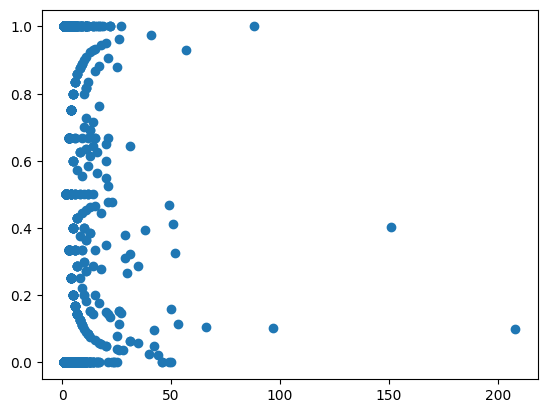

In [9]:
x_numbers_sorted = {k: v for k, v in sorted(x_numbers.items(), key=lambda item: len(item[1]), reverse=True)}
x_fracs = [sum(v) / len(v) for k, v in x_numbers_sorted.items()]
x_length = [len(v) for k, v in x_numbers_sorted.items()]

plt.scatter(x_length, x_fracs)

In [10]:
sum([1 if x == 0.0 else 0 for x in x_fracs])

2716

#### 2.2 Data splitting

Novel protein setting and novel peptide setting

In [11]:
pep_cluster = pickle.load(open(f"./raw_data/{cluster_threshold}_peptides_cluster_dict", "rb"))
cluster_pep = {}
for key, value in pep_cluster.items():
    if value not in cluster_pep:
        cluster_pep[value] = [key]
    else:
        cluster_pep[value].append(key) 
 
pro_cluster =  pickle.load(open(f"./raw_data/{cluster_threshold}_proteins_cluster_dict", "rb"))
cluster_pro = {}
for key, value in pro_cluster.items():
    if value not in cluster_pro:
        cluster_pro[value] = [key]
    else:
        cluster_pro[value].append(key)

In [12]:
def novel_single(cluster, dir_save, n_fold):
    folder = KFold(n_fold, shuffle=True)
    idx_list = list(cluster.values())
    fold_split = list(folder.split(idx_list))

    for n, splits in enumerate(fold_split):
        train, test = splits
        np.random.shuffle(train)
        val_point = int(len(train) * 0.9)
        val = train[val_point:]
        train = train[:val_point]
        
        train_names = []
        for i in train:
            train_names.extend(idx_list[i])
        test_names = []
        for i in test:
            test_names.extend(idx_list[i])
        val_names = []
        for i in val:
            val_names.extend(idx_list[i]) 
        
        save_path = f"./data/peptide_data/split_lists_{cluster_threshold}/{dir_save}/fold_{n}"
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        #2B2W_D_A_pep_D'
        with open(os.path.join(save_path, "train.txt"), "w") as f:
            for name in train_names:
                f.write("_".join(name.split("_")[:3]) + '\n')
        with open(os.path.join(save_path, "val.txt"), "w") as f:
            for name in val_names:
                f.write("_".join(name.split("_")[:3]) + '\n')
        with open(os.path.join(save_path, "test.txt"), "w") as f:
            for name in test_names:
                f.write("_".join(name.split("_")[:3]) + '\n')

In [13]:
novel_single(cluster_pep, "novel_peptide", 5)
novel_single(cluster_pro, "novel_protein", 5)

Novel protein and peptide setting, as 2 schemes, 4:4:1 and 9-fold

In [14]:
folder = KFold(3, shuffle=True)
pep_clu_list = list(cluster_pep.values())
pro_clu_list = list(cluster_pro.values())
pro_split = list(folder.split(pro_clu_list))
pep_split = list(folder.split(pep_clu_list))

idx_both = {}
for i, pro in enumerate(pro_split):
    
    pro_valid = []
    for idx, data in enumerate(pro_clu_list):
        if idx in pro[1]:
            pro_valid.extend(data)  # all ids in this single 
    pro_valid = list(map(lambda x: "_".join(x.split("_")[:3]), pro_valid))
    
    
    for k, pep in enumerate(pep_split):
        
        pep_valid = []
        for idx, data in enumerate(pep_clu_list):
            if idx in pep[1]:
                pep_valid.extend(data)  # all ids in this single split
        pep_valid = list(map(lambda x: "_".join(x.split("_")[:3]), pep_valid))

        idx_both[f"split_{i}_{k}"] = list(set(pro_valid).intersection(set(pep_valid)))

In [15]:
# 1. Splitting as 9 folds
counter = 0
for key in idx_both:
    test = idx_both[key]
    train = []
    for key2 in idx_both:
        if key2 != key:
            train.extend(idx_both[key2])
    np.random.shuffle(train)
    val_point = int(len(train) * 0.9)
    val = train[val_point:]
    train = train[:val_point]
    
    save_path = f"./data/peptide_data/split_lists_{cluster_threshold}/both_9/fold_{counter}"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    #2B2W_D_A_pep_D'
    with open(os.path.join(save_path, "train.txt"), "w") as f:
        for name in train:
            f.write("_".join(name.split("_")[:3]) + '\n')
    with open(os.path.join(save_path, "val.txt"), "w") as f:
        for name in val:
            f.write("_".join(name.split("_")[:3]) + '\n')
    with open(os.path.join(save_path, "test.txt"), "w") as f:
        for name in test:
            f.write("_".join(name.split("_")[:3]) + '\n')
    counter += 1

In [16]:
# 2. Splitting and 4 4 1
counter = 0
for key in idx_both:
    _, id1, id2 = key.split("_")
    id1 = int(id1)
    id2 = int(id2)
    train_ids = [f"split_{a}_{b}" for a in range(3) for b in range(3) if a != id1 and b != id2]  # training never overlap a selected one.
    val_ids = []
    for key2 in idx_both:
        if key2 not in train_ids and key2 != key and len(val_ids) == 0:
            val_ids = [key2]
    test_ids = [idx for idx in idx_both if idx not in val_ids and idx not in train_ids]
    
    save_path = f"./data/peptide_data/split_lists_{cluster_threshold}/both_4/fold_{counter}"
    if not os.path.exists(save_path):    
        os.makedirs(save_path)

    train, test, val = [], [], []
    for k in train_ids:
        train.extend(idx_both[k])
    for k in test_ids:
        test.extend(idx_both[k])
    for k in val_ids:
        val.extend(idx_both[k])
        
    with open(os.path.join(save_path, "train.txt"), "w") as f:
        for name in train:
            f.write(name + '\n')
    with open(os.path.join(save_path, "val.txt"), "w") as f:
        for name in val:
            f.write(name + '\n')
    with open(os.path.join(save_path, "test.txt"), "w") as f:
        for name in test:
            f.write(name + '\n')
    counter += 1

In [17]:
with open(f"raw_data/make_data/all_data_{cluster_threshold}.txt", "w") as f:  # here write all valid data into a single file
    for data in pep_cluster:
        dd = "_".join(data.split("_")[:3])
        f.write(dd + '\n')

In [ ]:
# generate data
! bash tools/prepare_data.sh
# generate peptide info
! python -m tools.prepare_data_peptide --file raw_data/make_data/all_data.txt

100%|██████████| 12240/12240 [1:04:11<00:00,  3.18it/s]


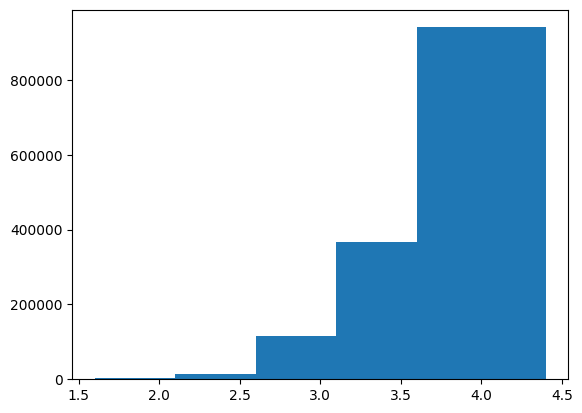

100%|██████████| 12240/12240 [1:25:03<00:00,  2.40it/s]  


for residue cutoff 2 the vertex cutoff is 0.6567224884829923
for residue cutoff 2.5 the vertex cutoff is 0.9559045954304691
for residue cutoff 3 the vertex cutoff is 1.5426898665152489
for residue cutoff 3.5 the vertex cutoff is 1.9833317289867245
for residue cutoff 4 the vertex cutoff is 2.442935951443259


In [2]:
# get cutoffs of data

data_path="data/peptide_data/processed_cv/"
files=os.listdir(data_path)
def get_distance_residue(data_path, data):
    peptide_info=torch.load(osp.join(data_path, f"{data}_peptide_info.pt"), weights_only=False)
    protein_graph=torch.load(osp.join(data_path, f"{data}_protein_graph.pt"), weights_only=False)
    protein_info=torch.load(osp.join(data_path, f"{data}_protein_info.pt"), weights_only=False)

    atom_names=protein_info.atom_names
    atom_coords=protein_info.x
    atom_residue_index=protein_info.reindex_residue_indices
    chain_ids=protein_info.chain_ids
    unique_chain_ids=np.unique(chain_ids)
    residue_index=protein_info.residue_indices
    
    nearest_res=protein_graph.nearest_residue
    mesh_coord=protein_graph.mesh_vertex
    
    peptide_position=peptide_info.cords
    peptide_position_exists=peptide_info.cord_exists
    peptide_residue_index=peptide_info.residue_index

    distance_between_peptide_and_protein=cdist(peptide_position, atom_coords)
    distance_between_peptide_and_protein[peptide_position_exists<1]=-1

    
    total_res_num=sum([len(_) for k, _ in protein_info.map_from_chain_id_to_seq.items()])
    min_dist_between_peptide_and_pro_res=np.zeros([len(peptide_position), total_res_num])-1
    row_cid=[]
    shift=0
    for cid, s in protein_info.map_from_chain_id_to_seq.items():
        pos=(np.array(chain_ids)==cid)
        unique_r_ids=np.unique(residue_index[pos])
        
        for rid in unique_r_ids:
            t=distance_between_peptide_and_protein[:, (pos&(residue_index==rid))].min(1)
            min_dist_between_peptide_and_pro_res[:, rid+shift]=t
        shift=shift+len(s)
        row_cid=row_cid+[cid for _ in s]
    return min_dist_between_peptide_and_pro_res, row_cid
    
def get_distance_vertex_to_residue(data_path, data):
    peptide_info=torch.load(osp.join(data_path, f"{data}_peptide_info.pt"), weights_only=False)
    protein_graph=torch.load(osp.join(data_path, f"{data}_protein_graph.pt"), weights_only=False)
    protein_info=torch.load(osp.join(data_path, f"{data}_protein_info.pt"), weights_only=False)

    atom_names=protein_info.atom_names
    atom_coords=protein_info.x
    atom_residue_index=protein_info.reindex_residue_indices
    chain_ids=protein_info.chain_ids
    unique_chain_ids=np.unique(chain_ids)
    residue_index=protein_info.residue_indices
    
    nearest_res=protein_graph.nearest_residue
    mesh_coord=protein_graph.mesh_vertex
    
    peptide_position=peptide_info.cords
    peptide_position_exists=peptide_info.cord_exists
    peptide_residue_index=peptide_info.residue_index

    distance_between_peptide_and_vertex=cdist(peptide_position, mesh_coord)
    distance_between_peptide_and_vertex[peptide_position_exists<1]=-1
    
    distance_between_peptide_and_residues=np.zeros([len(peptide_position), atom_residue_index.max()+1])-1
    for i in atom_residue_index:
        p=(nearest_res==i)
        if p.max():
            distance_between_peptide_and_residues[:, i]=distance_between_peptide_and_vertex[:, p].min(-1)
    
    return distance_between_peptide_and_residues
    
    #torch.save(Data(x=min_dist_between_peptide_and_pro_res, row_cid=row_cid), osp.join(data_path, f"{data}_distance_label.pt"))
def get_num_pos_pair_in_ardist(dist_matrix, cutoffs):
    mask=(dist_matrix>0)
    ret=[len(np.nonzero((mask&(dist_matrix<=_)))[0]) for _ in cutoffs]
    return ret

cutoffs=[2, 2.5, 3, 3.5, 4]
num_pos_in_diff_cutoffs=[0 for _ in cutoffs]

for file in tqdm(files):
    try:
        residue_dist=get_distance_residue(data_path+file, file)    
    except:
        continue
    n=get_num_pos_pair_in_ardist(residue_dist[0], cutoffs)
    for i,v in enumerate(n):
        num_pos_in_diff_cutoffs[i]+=v
plt.bar(cutoffs, num_pos_in_diff_cutoffs)
plt.show()
nonzero_dist=[]
for file in tqdm(files):
    try:
        d=get_distance_vertex_to_residue(data_path+file, file)    
    except:
        continue
    nonzero_dist.append(d[d>0])
nonzero_dist=np.concatenate(nonzero_dist, 0)
nonzero_dist=sorted(nonzero_dist)
for c,n in zip(cutoffs, num_pos_in_diff_cutoffs):
    print(f"for residue cutoff {c} the vertex cutoff is {nonzero_dist[n]}")
vertex_cutoffs=[nonzero_dist[_] for _ in num_pos_in_diff_cutoffs]
arg=" ".join([str(round(_, 3)) for _ in vertex_cutoffs])
    

In [ ]:
# generate gt based on vertex_cutoffs
!bash tools/generate_gt.sh "{arg}"

In [2]:
from transformers import T5Tokenizer, T5Model
import re
import torch

tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_bfd', do_lower_case=False)

model = T5Model.from_pretrained("Rostlab/prot_t5_xl_bfd").cuda()
for file in tqdm(os.listdir("data/peptide_data/processed_cv_pepnn")):
    data_path=f"data/peptide_data/processed_cv/{file}"
    if False:#osp.exists(osp.join(data_path, f"protein_prott5_emb.npy")):
        continue
    try:
        protein_info=torch.load(osp.join(data_path, f"{file}_protein_info.pt"), weights_only=False)
        label=torch.load(osp.join(data_path, f"{file}_residue_label.pt"), weights_only=False)
    except:
        print(file)
        continue
    
    row_info=label.row_info
    merge_embs={}#np.zeros([protein_info.reindex_residue_indices.max()+1, 1024])
    reindex_residue_indices=protein_info.reindex_residue_indices
    chain_ids=np.array(protein_info.chain_ids)
    residue_index=protein_info.residue_indices
    #print(osp.join(data_path, f"protein_prott5_emb.npy"))
    # atom level to res level
    select_idx=np.zeros(reindex_residue_indices.shape, dtype=bool)
    select_idx[:-1]=reindex_residue_indices[:-1]!=reindex_residue_indices[1:]
    select_idx[-1]=True
    reindex_residue_indices=reindex_residue_indices[select_idx]
    #assert len(reindex_residue_indices)==len(merge_embs)
    chain_ids=chain_ids[select_idx]
    residue_index=residue_index[select_idx]
    sort_keys=sorted(protein_info.map_from_chain_id_to_seq.keys())
    for c in sort_keys:
        s=protein_info.map_from_chain_id_to_seq[c][1]
        sequences_Example = [" ".join(list(s))]
        sequences_Example = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequences_Example]
        ids = tokenizer.batch_encode_plus(sequences_Example, add_special_tokens=True, padding=True)

        input_ids = torch.tensor(ids['input_ids']).cuda()
        attention_mask = torch.tensor(ids['attention_mask']).cuda()
    
        with torch.no_grad():
            embedding = model(input_ids=input_ids,attention_mask=attention_mask,decoder_input_ids=input_ids)
        assert c not in merge_embs
        merge_embs[c]=embedding[2].cpu().numpy()[0][:-1]
        assert len(merge_embs[c])==len(s), f"{len(merge_embs[c])} {len(s)}"
        #[(chain_ids==c)]=embedding[2].cpu().numpy()[0][residue_index[chain_ids==c]]
    
    save_embeds=[]
    
    for c in row_info:
        c=c[0]
        if c in merge_embs:
            save_embeds.append(merge_embs[c])
            merge_embs.pop(c)
    save_embeds=np.concatenate(save_embeds, 0)
    assert len(save_embeds)==len(row_info), f"{save_embeds.shape} {len(row_info)}"
    torch.save(save_embeds, osp.join(data_path, f"protein_prott5_emb.npy"))

    


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
  0%|▎                                                                                                          | 36/12240 [00:06<22:25,  9.07it/s]

1ORH_B_A


  1%|█▍                                                                                                        | 164/12240 [00:35<46:03,  4.37it/s]

2H51_C_A-B


  3%|██▊                                                                                                       | 328/12240 [01:15<56:12,  3.53it/s]

4JR1_C_A


  3%|███▎                                                                                                      | 377/12240 [01:25<41:24,  4.77it/s]

3QNW_Y_C-D


  4%|████▌                                                                                                     | 523/12240 [01:56<41:31,  4.70it/s]

5IAE_D_C


  5%|████▉                                                                                                     | 567/12240 [02:08<53:46,  3.62it/s]

5IAS_B_A


  6%|██████▊                                                                                                   | 789/12240 [02:55<25:34,  7.46it/s]

3D6H_C_A-B


 10%|██████████▏                                                                                              | 1183/12240 [04:25<23:06,  7.98it/s]

2HBZ_C_A-B


 10%|██████████▏                                                                                              | 1193/12240 [04:27<24:29,  7.52it/s]

5I9B_B_A


 10%|██████████▋                                                                                              | 1242/12240 [04:36<36:20,  5.04it/s]

5WNW_C_A-B


 11%|███████████▊                                                                                             | 1377/12240 [05:08<24:39,  7.34it/s]

1DVA_X_H


 11%|███████████▉                                                                                             | 1385/12240 [05:09<22:23,  8.08it/s]

3ITN_B_A


 12%|█████████████                                                                                            | 1529/12240 [05:40<36:36,  4.88it/s]

2H48_C_A-B


 13%|█████████████▏                                                                                           | 1531/12240 [05:40<30:49,  5.79it/s]

4QU5_B_A


 13%|█████████████▎                                                                                           | 1557/12240 [05:45<39:44,  4.48it/s]

2H4Y_C_A-B


 13%|█████████████▎                                                                                         | 1586/12240 [05:53<1:56:37,  1.52it/s]

3PD0_B_A


 14%|██████████████▊                                                                                          | 1725/12240 [06:26<53:33,  3.27it/s]

2BR8_J_A-E


 15%|███████████████▋                                                                                         | 1835/12240 [06:53<25:20,  6.84it/s]

4QUI_D_A


 16%|████████████████▌                                                                                        | 1925/12240 [07:14<37:07,  4.63it/s]

5IAK_B_A


 16%|████████████████▋                                                                                        | 1951/12240 [07:20<26:36,  6.45it/s]

6KD5_C_B


 17%|█████████████████▌                                                                                       | 2050/12240 [07:46<30:04,  5.65it/s]

2HBQ_C_A-B


 18%|██████████████████▍                                                                                      | 2145/12240 [08:07<30:40,  5.49it/s]

4QU9_E_A


 18%|██████████████████▋                                                                                      | 2184/12240 [08:17<35:19,  4.74it/s]

2H4W_C_A-B


 18%|███████████████████▏                                                                                     | 2237/12240 [08:28<29:17,  5.69it/s]

5JMO_G_A


 19%|███████████████████▍                                                                                     | 2266/12240 [08:35<28:07,  5.91it/s]

4JR0_D_B


 19%|████████████████████▏                                                                                    | 2347/12240 [08:57<36:00,  4.58it/s]

2J31_B_A
1PPG_I_E


 19%|████████████████████▍                                                                                    | 2376/12240 [09:03<23:45,  6.92it/s]

6BGS_B_A-C


 20%|█████████████████████▎                                                                                   | 2478/12240 [09:27<36:47,  4.42it/s]

6RQX_B_A


 23%|████████████████████████▏                                                                                | 2825/12240 [10:43<24:24,  6.43it/s]

4QUE_J_A


 23%|████████████████████████▍                                                                                | 2846/12240 [10:48<30:56,  5.06it/s]

1PJP_I_A


 24%|█████████████████████████▍                                                                               | 2960/12240 [11:14<35:12,  4.39it/s]

4QUD_D_A


 26%|███████████████████████████▎                                                                             | 3177/12240 [12:07<39:36,  3.81it/s]

2PUQ_I_H


 26%|███████████████████████████▌                                                                             | 3219/12240 [12:18<24:22,  6.17it/s]

5M3H_Y_A


 27%|████████████████████████████▍                                                                            | 3314/12240 [12:38<19:38,  7.57it/s]

1QCR_I_A-B


 27%|████████████████████████████▌                                                                            | 3328/12240 [12:40<15:27,  9.61it/s]

1FPH_F_H


 27%|████████████████████████████▋                                                                            | 3348/12240 [12:45<21:48,  6.80it/s]

5DXG_D_B


 28%|█████████████████████████████▏                                                                           | 3400/12240 [12:56<32:36,  4.52it/s]

6BFL_C_A-B
2DKO_I_A-B


 29%|██████████████████████████████▎                                                                          | 3527/12240 [13:28<44:08,  3.29it/s]

6RXH_D_B-E


 29%|██████████████████████████████▍                                                                          | 3544/12240 [13:33<33:09,  4.37it/s]

4Z0Y_E_A


 29%|██████████████████████████████▍                                                                          | 3550/12240 [13:34<38:36,  3.75it/s]

4AON_D_B-E


 30%|███████████████████████████████▉                                                                         | 3719/12240 [14:12<21:04,  6.74it/s]

4QUH_I_C


 32%|█████████████████████████████████▋                                                                       | 3931/12240 [15:05<21:25,  6.46it/s]

1AW8_A_B-E


 33%|██████████████████████████████████▎                                                                      | 4004/12240 [15:20<21:44,  6.31it/s]

4AWA_I_A


 33%|██████████████████████████████████▋                                                                      | 4045/12240 [15:29<21:09,  6.45it/s]

5JFT_F_A


 34%|███████████████████████████████████▎                                                                     | 4122/12240 [15:47<22:37,  5.98it/s]

6W1Z_X_A-B-C-D-E


 34%|███████████████████████████████████▉                                                                     | 4192/12240 [16:06<17:38,  7.60it/s]

2ID4_D_B


 35%|████████████████████████████████████▍                                                                    | 4242/12240 [16:16<34:20,  3.88it/s]

4Z0Y_H_B-D


 35%|█████████████████████████████████████▏                                                                   | 4328/12240 [16:34<22:39,  5.82it/s]

1HNE_I_E


 36%|██████████████████████████████████████▏                                                                  | 4457/12240 [17:04<18:36,  6.97it/s]

2JE4_C_A-B


 37%|██████████████████████████████████████▉                                                                  | 4545/12240 [17:26<25:17,  5.07it/s]

4QU0_E_A


 38%|███████████████████████████████████████▍                                                                 | 4598/12240 [17:36<19:21,  6.58it/s]

1P9U_G_B


 38%|████████████████████████████████████████▎                                                                | 4697/12240 [18:00<22:02,  5.70it/s]

2ZKS_C_A


 38%|████████████████████████████████████████▎                                                                | 4702/12240 [18:00<23:26,  5.36it/s]

5MT7_B_A


 38%|████████████████████████████████████████▎                                                                | 4705/12240 [18:01<16:35,  7.57it/s]

6L4U_M_B


 40%|█████████████████████████████████████████▉                                                               | 4888/12240 [18:44<16:46,  7.30it/s]

2H9H_I_A


 42%|████████████████████████████████████████████▎                                                            | 5170/12240 [19:42<22:50,  5.16it/s]

3I74_C_A


 43%|████████████████████████████████████████████▋                                                            | 5203/12240 [19:50<19:09,  6.12it/s]

6BG0_G_A-C


 43%|████████████████████████████████████████████▋                                                            | 5209/12240 [19:51<14:42,  7.97it/s]

6E4Z_P_H-L


 43%|█████████████████████████████████████████████                                                            | 5252/12240 [20:01<34:01,  3.42it/s]

2J30_B_A


 44%|██████████████████████████████████████████████▏                                                          | 5383/12240 [20:32<24:48,  4.61it/s]

1Z8G_L_A


 45%|███████████████████████████████████████████████▎                                                         | 5513/12240 [21:02<19:59,  5.61it/s]

6K33_bI_bB-bL-cL


 45%|███████████████████████████████████████████████▍                                                         | 5531/12240 [21:08<25:16,  4.42it/s]

6BGR_C_A-B


 47%|████████████████████████████████████████████████▊                                                        | 5696/12240 [21:49<19:55,  5.48it/s]

6BZ9_C_A-B


 47%|█████████████████████████████████████████████████▎                                                       | 5750/12240 [22:01<16:34,  6.52it/s]

8BQS_CO_CC-CF-CI-CJ-CK-CM-CN


 47%|█████████████████████████████████████████████████▌                                                       | 5778/12240 [22:07<18:37,  5.78it/s]

7WQA_B_A


 48%|██████████████████████████████████████████████████▏                                                      | 5854/12240 [22:24<17:58,  5.92it/s]

1S4V_D_B


 48%|██████████████████████████████████████████████████▌                                                      | 5890/12240 [22:31<22:50,  4.63it/s]

3MAT_I_A


 50%|████████████████████████████████████████████████████                                                     | 6062/12240 [23:06<12:25,  8.29it/s]

2RDL_I_A


 50%|████████████████████████████████████████████████████                                                     | 6072/12240 [23:09<27:15,  3.77it/s]

4MN3_B_A


 50%|████████████████████████████████████████████████████▎                                                    | 6096/12240 [23:15<17:35,  5.82it/s]

1CP3_C_A
2J33_B_A


 50%|████████████████████████████████████████████████████▍                                                    | 6111/12240 [23:17<24:51,  4.11it/s]

1OR8_C_A


 53%|███████████████████████████████████████████████████████▌                                                 | 6470/12240 [24:42<17:48,  5.40it/s]

6BFO_D_A-B


 53%|███████████████████████████████████████████████████████▌                                                 | 6476/12240 [24:43<13:59,  6.87it/s]

2H54_C_A-B


 53%|███████████████████████████████████████████████████████▊                                                 | 6504/12240 [24:49<11:17,  8.46it/s]

3V4O_B_A
2J32_B_A


 56%|██████████████████████████████████████████████████████████▍                                              | 6810/12240 [25:57<17:40,  5.12it/s]

6L4U_J_A-B-F


 56%|██████████████████████████████████████████████████████████▊                                              | 6855/12240 [26:08<25:22,  3.54it/s]

7WQ9_B_A


 56%|██████████████████████████████████████████████████████████▉                                              | 6867/12240 [26:10<15:29,  5.78it/s]

7AEG_B_A


 59%|█████████████████████████████████████████████████████████████▍                                           | 7167/12240 [27:13<17:56,  4.71it/s]

3D6F_C_A-B


 59%|█████████████████████████████████████████████████████████████▊                                           | 7205/12240 [27:22<27:11,  3.09it/s]

8A22_Uh_Bx


 59%|██████████████████████████████████████████████████████████████▎                                          | 7258/12240 [27:37<14:02,  5.91it/s]

5I9T_D_C


 60%|██████████████████████████████████████████████████████████████▉                                          | 7332/12240 [27:55<13:51,  5.90it/s]

6BGK_F_A-C


 60%|███████████████████████████████████████████████████████████████                                          | 7358/12240 [28:00<20:06,  4.05it/s]

5OBT_C_A


 61%|███████████████████████████████████████████████████████████████▋                                         | 7419/12240 [28:16<11:42,  6.86it/s]

1P8J_J_A


 62%|████████████████████████████████████████████████████████████████▉                                        | 7564/12240 [28:49<22:27,  3.47it/s]

4QUL_F_A


 65%|████████████████████████████████████████████████████████████████████                                     | 7934/12240 [30:22<15:31,  4.62it/s]

1DE7_A_H


 65%|████████████████████████████████████████████████████████████████████                                     | 7938/12240 [30:23<16:38,  4.31it/s]

1JXQ_F_C


 68%|███████████████████████████████████████████████████████████████████████▏                                 | 8303/12240 [31:54<06:58,  9.42it/s]

5IAN_B_A
2WUC_I_A


 68%|███████████████████████████████████████████████████████████████████████▉                                 | 8379/12240 [32:19<16:36,  3.87it/s]

2CJX_I_A-B


 69%|████████████████████████████████████████████████████████████████████████▎                                | 8427/12240 [32:30<07:28,  8.49it/s]

1KHQ_I_A


 69%|████████████████████████████████████████████████████████████████████████▌                                | 8458/12240 [32:36<08:18,  7.58it/s]

5QU2_D_A


 76%|████████████████████████████████████████████████████████████████████████████████                         | 9338/12240 [36:11<08:31,  5.68it/s]

3FDM_D_A


 77%|████████████████████████████████████████████████████████████████████████████████▌                        | 9395/12240 [36:23<07:58,  5.95it/s]

3D6M_C_A-B


 78%|█████████████████████████████████████████████████████████████████████████████████▌                       | 9509/12240 [36:56<15:24,  2.95it/s]

8GYM_qM_qC-qD-qE-qc


 78%|██████████████████████████████████████████████████████████████████████████████████                       | 9567/12240 [37:10<08:22,  5.32it/s]

6BGQ_K_A-B


 80%|███████████████████████████████████████████████████████████████████████████████████▌                     | 9742/12240 [37:51<17:16,  2.41it/s]

6BG1_B_A-C


 81%|█████████████████████████████████████████████████████████████████████████████████████▎                   | 9938/12240 [38:43<05:15,  7.29it/s]

3PRK_I_E


 83%|██████████████████████████████████████████████████████████████████████████████████████                  | 10131/12240 [39:33<07:30,  4.69it/s]

5N89_C_B-D


 84%|███████████████████████████████████████████████████████████████████████████████████████                 | 10241/12240 [40:01<08:45,  3.80it/s]

5IBR_B_A


 85%|████████████████████████████████████████████████████████████████████████████████████████▎               | 10399/12240 [40:38<05:06,  6.01it/s]

2HBR_C_A-B


 86%|█████████████████████████████████████████████████████████████████████████████████████████               | 10484/12240 [41:05<05:26,  5.38it/s]

4DM9_X_A


 86%|█████████████████████████████████████████████████████████████████████████████████████████▊              | 10571/12240 [41:23<04:55,  5.65it/s]

1DLK_F_D


 87%|██████████████████████████████████████████████████████████████████████████████████████████▋             | 10666/12240 [41:45<04:49,  5.43it/s]

5F2U_C_A


 87%|██████████████████████████████████████████████████████████████████████████████████████████▋             | 10678/12240 [41:47<05:31,  4.71it/s]

1H9H_I_E


 89%|████████████████████████████████████████████████████████████████████████████████████████████▊           | 10917/12240 [42:44<05:15,  4.19it/s]

2HBY_C_A-B


 89%|████████████████████████████████████████████████████████████████████████████████████████████▊           | 10922/12240 [42:45<04:11,  5.25it/s]

5IAJ_B_A


 90%|█████████████████████████████████████████████████████████████████████████████████████████████▌          | 11014/12240 [43:06<04:43,  4.32it/s]

2CJY_I_A-B


 90%|██████████████████████████████████████████████████████████████████████████████████████████████          | 11069/12240 [43:20<03:41,  5.28it/s]

5IAR_B_A


 91%|██████████████████████████████████████████████████████████████████████████████████████████████▎         | 11105/12240 [43:28<04:38,  4.07it/s]

1EKB_C_B


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████   | 11893/12240 [46:41<00:53,  6.54it/s]

6BDV_C_A-B


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████  | 12015/12240 [47:11<00:47,  4.70it/s]

1EFG_B_A


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎| 12158/12240 [47:48<00:18,  4.48it/s]

6RFK_I_S


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 12240/12240 [48:07<00:00,  4.24it/s]


In [4]:
import torch
import esm
import os
from tqdm import tqdm
import os.path as osp
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()
model=model.cuda()
for file in tqdm(os.listdir("data/peptide_data/processed_cv_pepnn")):
    data_path=f"data/peptide_data/processed_cv_pepnn/{file}"
    if False:#osp.exists(osp.join(data_path, f"protein_prott5_emb.npy")):
        continue
    #try:
    try:
        protein_info=torch.load(osp.join(data_path, f"{file}_protein_info.pt"), weights_only=False)
        label=torch.load(osp.join(data_path, f"{file}_residue_label.pt"), weights_only=False)
    except:
        continue
    
    #except:
    #    print(file)
    #    continue
    
    row_info=label.row_info
    merge_embs={}#np.zeros([protein_info.reindex_residue_indices.max()+1, 1024])
    reindex_residue_indices=protein_info.reindex_residue_indices
    chain_ids=np.array(protein_info.chain_ids)
    residue_index=protein_info.residue_indices
    #print(osp.join(data_path, f"protein_prott5_emb.npy"))
    # atom level to res level
    select_idx=np.zeros(reindex_residue_indices.shape, dtype=bool)
    select_idx[:-1]=reindex_residue_indices[:-1]!=reindex_residue_indices[1:]
    select_idx[-1]=True
    reindex_residue_indices=reindex_residue_indices[select_idx]
    #assert len(reindex_residue_indices)==len(merge_embs)
    chain_ids=chain_ids[select_idx]
    residue_index=residue_index[select_idx]
    sort_keys=sorted(protein_info.map_from_chain_id_to_seq.keys())
    for c in sort_keys:
        s=protein_info.map_from_chain_id_to_seq[c][1]
        data = [("s", s)]
        
        batch_labels, batch_strs, batch_tokens = batch_converter(data)
        with torch.no_grad():
            results = model(batch_tokens.cuda(), repr_layers=[33], return_contacts=False)
        assert c not in merge_embs
        merge_embs[c]=results["representations"][33][0][1:-1].detach().cpu().numpy()
        assert len(merge_embs[c])==len(s), f"{len(merge_embs[c])} {len(s)}"
        #[(chain_ids==c)]=embedding[2].cpu().numpy()[0][residue_index[chain_ids==c]]
    
    save_embeds=[]
    
    for c in row_info:
        c=c[0]
        if c in merge_embs:
            save_embeds.append(merge_embs[c])
            merge_embs.pop(c)
    save_embeds=np.concatenate(save_embeds, 0)
    assert len(save_embeds)==len(row_info), f"{save_embeds.shape} {len(row_info)}"
    torch.save(save_embeds, osp.join(data_path, f"protein_esm_emb.npy"))

    


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12240/12240 [24:10<00:00,  8.44it/s]


## 3. Miscs.

- Clean some data that are invalid in structures (see below)
- generate binary label of peptide/protein sequences

### 3.1 Clean invalid data

This part will be conducted after data preprocessing.

delete unexpected files, the peptide locates insides protein / cannot processed by MSMS

In [3]:
with open("./raw_data/make_data/left.txt", "w") as f, open(f"./data/peptide_data/split_lists/all_data_pepnn.txt", "w") as f2:
    for data in tqdm(os.listdir("./data/peptide_data/processed_cv_pepnn")):
        target = data.split("_")[-1]
        checker = sorted([
            #f"{data}_pro.pdb",
            #f"{data}.pdb",
            f"{data}_peptide_info.pt",
            f"{data}_protein_info.pt",
            #f"{data}_protein_graph.pt",
            "protein_esm_emb.npy"
        ])
        ds = sorted(os.listdir(f"./data/peptide_data/processed_cv_pepnn/{data}"))
        ds=[_ for _ in ds if "label" not in _ and "sim" not in _]
      
        if ds != checker:
            f.write(data + '\n')
            #print(data)
            #shutil.rmtree(f"./data/peptide_data/processed_cv/{data}")  # please check the real problem before you delete this
        else:
            f2.write(data + '\n')
            

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12240/12240 [00:03<00:00, 3678.29it/s]


**The all data here, is the final available data.** 

you may restart notebook now.

In [2]:
cluster_threshold=0.3
data_avail = [x.strip() for x in open(f"data/peptide_data/split_lists/all_data_pepnn.txt", "r").readlines()]

for dir in os.listdir(f"./data/peptide_data/split_lists_{cluster_threshold}"):
    print(f"./data/peptide_data/split_lists_{cluster_threshold}")
    if osp.isdir(f"./data/peptide_data/split_lists_{cluster_threshold}/{dir}"):
        for subdir in os.listdir(f"./data/peptide_data/split_lists_{cluster_threshold}/{dir}"):
            t=0
            r=0
            #print(f"./data/peptide_data/data_source_{cluster_threshold}/{dir}/{subdir}")
            if not os.path.exists(f"./data/peptide_data/data_source_{cluster_threshold}/{dir}/{subdir}"):
                os.makedirs(f"./data/peptide_data/data_source_{cluster_threshold}/{dir}/{subdir}")
            for tp in ['train', 'val', 'test']:
                print(f"./data/peptide_data/split_lists_{cluster_threshold}/{dir}/{subdir}/{tp}.txt", f"./data/peptide_data/data_source_{cluster_threshold}/{dir}/{subdir}/{tp}.txt")
                with open(f"./data/peptide_data/split_lists_{cluster_threshold}/{dir}/{subdir}/{tp}.txt", "r") as ori, open(f"./data/peptide_data/data_source_{cluster_threshold}/{dir}/{subdir}/{tp}.txt", "w") as new:
                    for line in ori.readlines():
                        r+=1
                        if line.strip() not in data_avail:
                            t+=1
                            #print(t, r)
                            continue
                        else:
                            new.write(line)
                        

./data/peptide_data/split_lists_0.4
./data/peptide_data/split_lists_0.4/both_4/fold_3/train.txt ./data/peptide_data/data_source_0.4/both_4/fold_3/train.txt
./data/peptide_data/split_lists_0.4/both_4/fold_3/val.txt ./data/peptide_data/data_source_0.4/both_4/fold_3/val.txt
./data/peptide_data/split_lists_0.4/both_4/fold_3/test.txt ./data/peptide_data/data_source_0.4/both_4/fold_3/test.txt
./data/peptide_data/split_lists_0.4/both_4/fold_6/train.txt ./data/peptide_data/data_source_0.4/both_4/fold_6/train.txt
./data/peptide_data/split_lists_0.4/both_4/fold_6/val.txt ./data/peptide_data/data_source_0.4/both_4/fold_6/val.txt
./data/peptide_data/split_lists_0.4/both_4/fold_6/test.txt ./data/peptide_data/data_source_0.4/both_4/fold_6/test.txt
./data/peptide_data/split_lists_0.4/both_4/fold_2/train.txt ./data/peptide_data/data_source_0.4/both_4/fold_2/train.txt
./data/peptide_data/split_lists_0.4/both_4/fold_2/val.txt ./data/peptide_data/data_source_0.4/both_4/fold_2/val.txt
./data/peptide_data/

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12240/12240 [00:57<00:00, 214.25it/s]


4.647193438333737


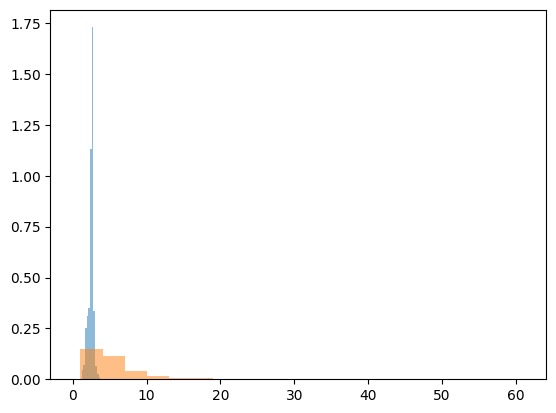

In [ ]:
# ana data distance distribution
files=os.listdir("data/peptide_data/processed_cv/")
res_min=[]
all_v=[]
for d in tqdm(files):
    if os.path.exists(os.path.join("data/peptide_data/processed_cv/", d, f"{d}_residue_label.pt")):
        data=torch.load(os.path.join("data/peptide_data/processed_cv/", d, f"{d}_residue_label.pt"))
        x=data.x
        tx=x.min(1)
        x=x[x>-1]
        res_min.append(x.min())
        all_v.append(tx[tx>0])

plt.hist(res_min, bins=20, alpha=0.5, density=True)
plt.hist(np.concatenate(all_v,0), alpha=0.5, bins=20, density=True)
print(max(res_min), np.quantile(res_min, 0.9))

(array([3.57752722e-04, 0.00000000e+00, 0.00000000e+00, 3.57752722e-04,
        2.14651633e-03, 4.54345957e-02, 6.97617808e-02, 2.53288927e-01,
        3.12318126e-01, 3.49524409e-01, 1.13264512e+00, 1.72973441e+00,
        3.33067784e-01, 6.68997590e-02, 2.68314541e-02, 1.07325817e-02,
        2.50426905e-03, 7.15505444e-04, 3.57752722e-04, 3.57752722e-04]),
 array([0.03574939, 0.26632159, 0.49689379, 0.727466  , 0.9580382 ,
        1.1886104 , 1.4191826 , 1.64975481, 1.88032701, 2.11089921,
        2.34147141, 2.57204362, 2.80261582, 3.03318802, 3.26376022,
        3.49433243, 3.72490463, 3.95547683, 4.18604903, 4.41662124,
        4.64719344]),
 <BarContainer object of 20 artists>)

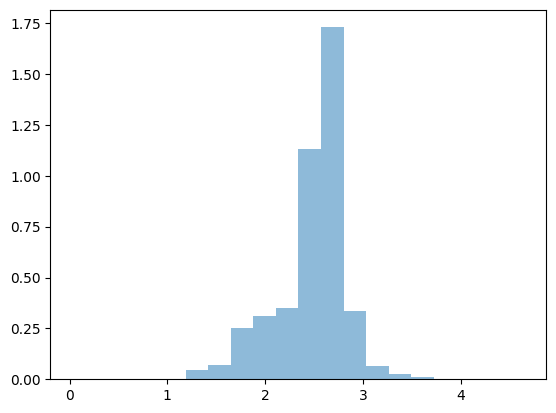

In [7]:
plt.hist(res_min, bins=20, alpha=0.5, density=True)

### 3.2 Binary label

This part could be temporary, maybe move to preprocessing in the future

In [ ]:
'''
def generate_coordinate(name):
    parser = biopdb.PDBParser(QUIET=True)
    struct = parser.get_structure("name", f"./data/peptide_data/processed_cv/{name}/{name}.pdb")
    struct = struct[0]
    
    coord_dict = {}
    atom_coords_all = []
    atom_counter = 0
    for chain in struct:
        for idx, residue in enumerate(chain):
            atom_coords = []
            for atom in residue:
                atom_coords.append(atom_counter)
                atom_counter += 1
                atom_coords_all.append(atom.get_coord())
            coord_dict[idx] = np.array(atom_coords)

                
    # atom_coords = np.stack(atom_coords)
    return np.stack(atom_coords_all), coord_dict

def protein_bin_label(prot_coord, vertex, label, residue_dict):
    label_prot = np.zeros(prot_coord.shape[0], dtype=np.int64)
    for i in range(prot_coord.shape[0]):
        distance = np.linalg.norm(vertex - prot_coord[i], axis=1)
        closest_index = np.argmin(distance)
        label_prot[i] = label[closest_index]  # this is the prot label for every atom
    
    # residue will be positive if any atom is positive
    res_label = np.zeros(len(residue_dict.keys()), dtype=np.int64)
    for i in range(len(residue_dict.keys())):
        if sum(label_prot[residue_dict[i]]) == 0:
            res_label[i] = 0
        else:
            res_label[i] = 1
    
    return res_label
'''

In [ ]:
'''
for data in tqdm(os.listdir("./data/peptide_data/processed_cv")):
    prot_coord, residue_dict = generate_coordinate(data)
    vertex_coord = torch.load(f"./data/peptide_data/processed_cv/{data}/{data}_protein_graph.pt")
    peptide_graph = torch.load(f"./data/peptide_data/processed_cv/{data}/{data}_peptide_graph.pt")
    labels_pos = torch.load(f"./data/peptide_data/processed_cv/{data}/{data}_label.pt")[0]
    
    peptide_pos = [x[0] for x in labels_pos]
    vertex_pos = [x[1] for x in labels_pos]
    peptide_label = np.array([1 if x in peptide_pos else 0 for x in range(len(peptide_graph.residue_graph))])
    vertex_label = [1 if x in vertex_pos else 0 for x in range(len(vertex_coord.mesh_vertex))]
    
    prot_label = protein_bin_label(prot_coord, vertex_coord.mesh_vertex, vertex_label, residue_dict)
    torch.save((peptide_label, prot_label), f"./data/peptide_data/processed_cv/{data}/{data}_binary_label.pt")  
# too long, go to sbatch
'''

In [ ]:
'''
with open("./raw_data/make_data/left.txt", "w") as f, open("./data/peptide_data/split_lists/all_data.txt", "w") as f2:
    for data in os.listdir("./data/peptide_data/processed_cv"):
        target = data.split("_")[-1]
        checker = sorted([
            f"{data}_pro.pdb",
            f"{data}.pdb",
            f"{data}_label.pt",
            f"{data}_peptide_coords.pt",
            f"{data}_peptide_graph.pt",
            f"{data}_peptide_info.pt",
            f"{data}_protein_graph.pt",
            f"{data}_binary_label.pt"
        ])
        ds = sorted(os.listdir(f"./data/peptide_data/processed_cv/{data}"))
        if ds != checker:
            print(data)
            #f.write(data + '\n')
            #shutil.rmtree(f"./data/peptide_data/processed_cv/{data}")  # please check the real problem before you delete this
        else:
            continue
            #f2.write(data + '\n')
'''

In [ ]:
for data in tqdm(os.listdir("./data/peptide_data/processed_cv")):
    shutil.copy(f"./data/peptide_data/processed_cv/{data}/{data}_binary_label.pt", "./labels/")